In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import random
from shapely.geometry import Point
from shapely import contains_xy

# Import functions from functions.py
from functions import generate_random_location_within_map_domain, get_flood_depth, calculate_basic_flood_damage, floodplain_multipolygon
import networkx as nx
from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
from mesa import batch_run
import geopandas as gpd
import rasterio as rs
import matplotlib.pyplot as plt
# Import the agent class(es) from agents.py
from agents import Households
from agents import Government
from rbb import OrganizationInstrument

# Import functions from functions.py
from functions import get_flood_map_data, calculate_basic_flood_damage
from functions import map_domain_gdf, floodplain_gdf

from model import AdaptationModel

In [2]:
dyke = OrganizationInstrument(name = 'Dyke', cost = 8, completion_time = 5, protection_level = 0.7, status = 1)
wetland = OrganizationInstrument(name = 'Wetland', cost = 5,  completion_time = 2, protection_level = 0.4, status = 1)  
options_list = [dyke, wetland]

In [3]:
params = {
    "options_list": None,
    "number_of_households": 100,
    "flood_map_choice": 'harvey',
    "network": 'watts_strogatz', #["erdos_renyi", "barabasi_albert", "watts_strogatz"],
    "probability_of_network_connection": 0.4,
    "number_of_edges" : 3,"number_of_nearest_neighbours" : 5,

    "flood_probability" : 0.05,
    "economic_status": 'neutral',
    "intention_action_gap" : 0.3,
    "low_threshold" : 0.6,
    "medium_threshold" : 0.7,
    "high_threshold" : 0.8,
    "upper_budget_threshold" : 7000,
    "lower_budget_threshold" : 3000,
    "elevation_time" : 4,
    "elevation_cost" : 5000,
    "elevation_protection" : 0.3,
    "elevation_effectiveness" : 1,
    "wet_proofing_time" : 2,
    "wet_proofing_cost" : 3000,
    "wet_proofing_effectiveness" : 0.4,
    "dry_proofing_time" : 1,
    "dry_proofing_cost" : 1500,
    "dry_proofing_protection" : 1,
    "dry_proofing_effectiveness" : 0.85,
    "max_damage_costs" : 5000,
    "flood_risk_threshold": 1.5,
    "public_concern_threshold": 0.6,
    "damage_threshold": 0.3,
    "high_risk_bound": 2.9,
    "lower_risk_bound": 1.9,
    "gov_detector": 0,
    "gov_structure": 'centralised',
          }

results = batch_run(
    AdaptationModel,
    parameters=params,
    iterations=70,
    max_steps=120,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)

  0%|          | 0/70 [00:00<?, ?it/s]

In [4]:
complete_df = pd.DataFrame(results)
complete_df.to_csv('dataframes/df_basecase_n70_randomseed_new2.csv')
df_n70 = pd.read_csv('dataframes/df_basecase_n70_randomseed_new2.csv')
subset_df = df_n70[['iteration', 'Step', 
                    'options_list', 'number_of_households', 
                    'Average Adaptation Motivation', 'Average flood damage', 
                    'total_adapted_households', 'total_decisions_to_adapt']]
df_no_agent = subset_df.drop_duplicates().reset_index().drop(columns=['index'])
df_last_steps = df_no_agent[df_no_agent['Step'] == 120].reset_index().drop(columns=['index'])
cum_avg_am = df_last_steps['Average Adaptation Motivation'].expanding().mean()
cum_avg_fd = df_last_steps['Average flood damage'].expanding().mean()
cum_avg_ah = df_last_steps['total_adapted_households'].expanding().mean()
cum_avg_da = df_last_steps['total_decisions_to_adapt'].expanding().mean()

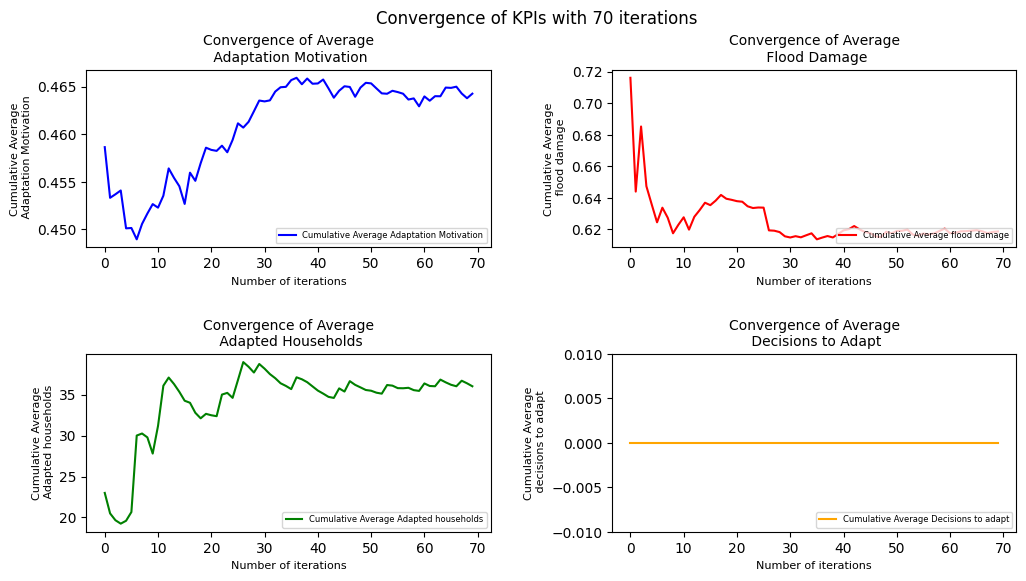

In [5]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,6))
fig.suptitle('Convergence of KPIs with 70 iterations')

sns.lineplot(x=df_last_steps['iteration'], y=cum_avg_am, label='Cumulative Average Adaptation Motivation', color='blue', ax=ax1)
ax1.set_title('Convergence of Average\n Adaptation Motivation', fontsize=10)
ax1.set_xlabel('Number of iterations', fontsize=8)
ax1.set_ylabel('Cumulative Average\n Adaptation Motivation', fontsize=8)
ax1.legend(loc='lower right', prop={'size': 6})

sns.lineplot(x=df_last_steps['iteration'], y=cum_avg_fd, label='Cumulative Average flood damage', color='red', ax=ax2)
ax2.set_title('Convergence of Average\n Flood Damage', fontsize=10)
ax2.set_xlabel('Number of iterations', fontsize=8)
ax2.set_ylabel('Cumulative Average\n flood damage', fontsize=8)
ax2.legend(loc='lower right', prop={'size': 6})

sns.lineplot(x=df_last_steps['iteration'], y=cum_avg_ah, label='Cumulative Average Adapted households', color='green', ax=ax3)
ax3.set_title('Convergence of Average\n Adapted Households', fontsize=10)
ax3.set_xlabel('Number of iterations', fontsize=8)
ax3.set_ylabel('Cumulative Average\n Adapted households', fontsize=8)
ax3.legend(loc='lower right', prop={'size': 6})

sns.lineplot(x=df_last_steps['iteration'], y=cum_avg_da, label='Cumulative Average Decisions to adapt', color='orange', ax=ax4)
ax4.set_title('Convergence of Average\n Decisions to Adapt', fontsize=10)
ax4.set_xlabel('Number of iterations', fontsize=8)
ax4.set_ylabel('Cumulative Average\n decisions to adapt', fontsize=8)
ax4.set_ylim(-0.01, 0.01)
ax4.legend(loc='lower right', prop={'size': 6})

plt.subplots_adjust(hspace=0.6)
plt.subplots_adjust(wspace=0.3)
plt.savefig("figures/Convergence_KPIs_n70_new2.png", dpi=100, bbox_inches='tight')
plt.show()